## Realise DANN on transfer learning task on SVNH → MNIST



In [1]:
#Importing needed libraries
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from torchvision import datasets, transforms
import numpy as np

## Define Gradient Reversal Layer (GRL)



In [2]:
from torch.autograd import Function

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):    #alpha controls the degree of reversal applied to the gradient
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [3]:
import copy
import torch.nn as nn

class GradientReverse(nn.Module):
    # Initialize the class with an alpha value, used to scale the reversed gradient
    def __init__(self, alpha, *args, **kwargs):
        "Reverse GR layer hook"  # A simple docstring describing the purpose of the class
        super().__init__(*args, **kwargs)  # Call the parent class initializer
        # Alpha controls how strongly the gradient is reversed
        self.alpha = torch.tensor(alpha, requires_grad=False)
        # Ensure that alpha is positive, otherwise raise an assertion error
        assert alpha > 0, 'alpha must be > 0'
        # Print the negative alpha value, indicating the scale of the reversed gradient
        print(f"The gradient will be multiplied by: {-alpha}")

    # Forward pass for the layer; x is the input, and self.alpha is the scaling factor
    def forward(self, x):
        # Apply the reverse layer operation during the forward pass
        return ReverseLayerF.apply(x, self.alpha)

# Function to test the gradient reversal mechanism
def test_grad_reverese(alpha):
    # Define a simple Mean Squared Error (MSE) loss function for testing
    criterion = torch.nn.MSELoss()
    # Generate random input and output tensors for testing
    input, output = torch.randn(8, 5), torch.randn(8, 1)

    # Define a simple network with linear layers
    network = nn.Sequential(nn.Linear(5, 1), torch.nn.Linear(1, 1))
    # Create a reversed version of the network with the gradient reversal layer
    revnetwork = nn.Sequential(
        copy.deepcopy(network),  # Create a copy of the original network
        GradientReverse(alpha),  # Insert the GradientReverse layer
    )

    # Compute the loss for the original network and perform backpropagation
    criterion(network(input), output).backward()
    # Compute the loss for the reversed network and perform backpropagation
    criterion(revnetwork(input), output).backward()

    # Compare the gradients of the original and reversed networks
    for p1, p2 in zip(network.parameters(), revnetwork.parameters()):
        print("-" * 100)  # Print a separator line
        # Print the gradient of the original network
        print(f"original: {p1.grad}")
        # Print the scaled gradient of the reversed network
        print(f"reversed: {p2.grad/alpha}")
        # Assert that the reversed gradient is approximately equal to the negative of the original gradient
        assert torch.isclose(p1.grad, ((-p2.grad) / alpha)).all()
    print("-" * 100)  # Print another separator line

# Run the test function with alpha set to 1
test_grad_reverese(1)

The gradient will be multiplied by: -1
----------------------------------------------------------------------------------------------------
original: tensor([[ 0.0830, -0.0223,  0.0050,  0.2087,  0.0664]])
reversed: tensor([[-0.0830,  0.0223, -0.0050, -0.2087, -0.0664]])
----------------------------------------------------------------------------------------------------
original: tensor([-0.3502])
reversed: tensor([0.3502])
----------------------------------------------------------------------------------------------------
original: tensor([[-0.0297]])
reversed: tensor([[0.0297]])
----------------------------------------------------------------------------------------------------
original: tensor([2.1405])
reversed: tensor([-2.1405])
----------------------------------------------------------------------------------------------------


## Deifne the main model architectures

we define the feature extractor, the label predictor and the domain classifier.

In [4]:
class CNNModel(nn.Module):   # The CNNModel class defines a neural network with both a feature extraction
                             # module and two classifiers: one for classifying image classes and one for domain classification.
    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()     # Feature extraction layers
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()  # Class classification branch
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout2d())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax())

        self.domain_classifier = nn.Sequential()   # Domain classification branch
        self.domain_classifier.add_module('d_fc1', nn.Linear(50 * 4 * 4, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        # Expand the input data to 3 channels (RGB) and resize to 32x32 if necessary
        input_data = input_data.expand(input_data.data.shape[0], 3, 32, 32)
        # Pass the input through the feature extraction layers
        feature = self.feature(input_data)
        # Flatten the extracted features
        feature = feature.view(-1, 50 * 4 * 4)
        # Reverse the gradient flow with the alpha scaling factor for the domain classifier
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

## Prepare dataloader


In [34]:
# Import necessary libraries
from PIL import Image
import os
import tarfile
import torch
from torchvision import datasets, transforms

# Dataset class to handle loading custom images (e.g., MNIST-M)
class GetLoader(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root  # Root directory of the dataset
        self.transform = transform  # Transformations to apply on images

        # Read the file containing the list of image paths and labels
        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)  # Number of samples

        # Initialize lists to store image paths and labels
        self.img_paths = []
        self.img_labels = []

        # Parse the data list and split image paths and labels
        for data in data_list:
            self.img_paths.append(data[:-3].strip())  # Image path
            self.img_labels.append(int(data[-2]))  # Label

    # Function to get one sample from the dataset
    def __getitem__(self, item):
        img_path, label = self.img_paths[item], self.img_labels[item]
        img = Image.open(os.path.join(self.root, img_path)).convert('RGB')  # Load image and convert to RGB

        if self.transform is not None:
            img = self.transform(img)  # Apply transformations
            label = int(label)  # Convert label to integer

        return img, label  # Return image and its label

    # Function to get the number of samples in the dataset
    def __len__(self):
        return self.n_data

# Transforms for both SVHN and MNIST (resizing, normalization)
transform_svhn = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize SVHN images to 32x32
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST images to 32x32
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale channel
])

# Loading the SVHN and MNIST datasets
source_dataset = datasets.SVHN(root='data', split='train', download=True, transform=transform_svhn)  # SVHN (source domain)
target_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform_mnist)  # MNIST (target domain)

# Define paths for datasets
source_image_root = os.path.join('..', 'dataset', 'SVHN')
target_image_root = os.path.join('..', 'dataset', 'MNIST')

# Set consistent batch size for both source and target
batch_size = 128

# Dataloaders for SVHN (source) and MNIST (target) datasets
dataloader_source = torch.utils.data.DataLoader(
    dataset=source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

dataloader_target = torch.utils.data.DataLoader(
    dataset=target_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


Using downloaded and verified file: data/train_32x32.mat


Next, we show some data in SVHN dataset and MNIST dataset.

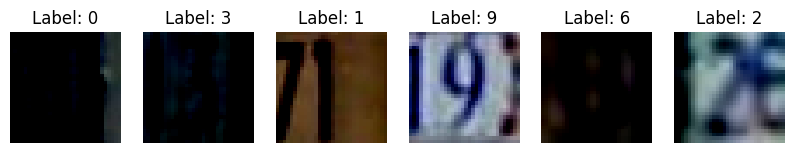

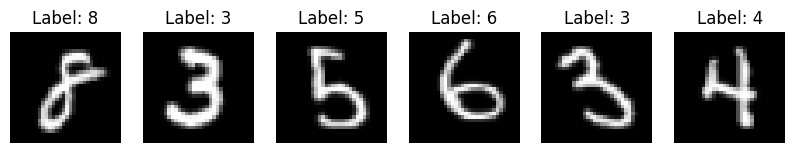

In [36]:
import matplotlib.pyplot as plt

# Function to show a batch of images (handles both RGB and grayscale)
def show_images(images, labels, n=6, dataset_type='MNIST'):
    plt.figure(figsize=(10, 5))

    for i in range(n):
        # Select the image and label
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose to (H, W, C) for displaying

        # Plot the image
        plt.subplot(1, n, i + 1)

        # Check if dataset is RGB (SVHN) or grayscale (MNIST)
        if dataset_type == 'SVHN':
            plt.imshow(image)  # No colormap needed for RGB images
        else:
            plt.imshow(image.squeeze(), cmap='gray')  # Squeeze and use 'gray' colormap for MNIST

        label = labels[i].item()  # Extract label
        plt.title(f'Label: {label}')
        plt.axis('off')  # Hide axis for better visual effect

    plt.show()

# Function to load a sample of images from a dataset
def load_sample_data(dataset, n=6):
    # Choose n random images and labels from the dataset
    indices = torch.randint(0, len(dataset), (n,))
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    return images, labels

# Load and display a batch of SVHN images
svhn_images, svhn_labels = load_sample_data(source_dataset, n=6)
show_images(svhn_images, svhn_labels, n=6, dataset_type='SVHN')

# Load and display a batch of MNIST images
mnist_images, mnist_labels = load_sample_data(target_dataset, n=6)
show_images(mnist_images, mnist_labels, n=6, dataset_type='MNIST')


## Traning process

In [40]:
# Dataloaders for SVHN and MNIST datasets
dataloader_source = torch.utils.data.DataLoader(dataset=source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_target = torch.utils.data.DataLoader(dataset=target_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Training loop optimization   ##Transfer learning here presents the model is trained on the source domain(SVHN) and adapted to the target domain (MNIST).##
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_domain_loss = 0
    correct_class = 0
    total_samples = 0

    # Iterate over a limited number of batches
    for (source_data, target_data) in limited_batches:  # Use the limited batches
        source_imgs, source_labels = source_data
        target_imgs, target_labels = target_data
        source_imgs, source_labels = source_imgs.to(device), source_labels.to(device)
        target_imgs, target_labels = target_imgs.to(device), target_labels.to(device)

        # Convert MNIST images to have 3 channels
        target_imgs = target_imgs.repeat(1, 3, 1, 1)

        # Combine datasets for domain classification (SVHN: source, MNIST: target)
        combined_imgs = torch.cat((source_imgs, target_imgs), 0)
        domain_labels = torch.cat((
            torch.zeros(source_imgs.size(0)).long(),  # SVHN as source (label 0)
            torch.ones(target_imgs.size(0)).long()    # MNIST as target (label 1)
        ), 0).to(device)

        optimizer.zero_grad()

        # Forward pass
        class_outputs, domain_outputs = model(combined_imgs, alpha)

        # Compute class loss only for the source domain (first part of class_outputs)
        class_loss = criterion_class(class_outputs[:source_imgs.size(0)], source_labels)

        # Compute domain loss for both source and target domains (entire domain_outputs)
        domain_loss = criterion_domain(domain_outputs, domain_labels)

        # Combine both losses
        loss = class_loss + domain_loss


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track losses and accuracy
        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_domain_loss += domain_loss.item()

        # Track accuracy for source domain classification
        _, predicted_class = torch.max(class_outputs[:source_imgs.size(0)], 1)
        correct_class += (predicted_class == source_labels).sum().item()
        total_samples += source_labels.size(0)

    # Epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss:.4f}, "
          f"Class Accuracy: {100 * correct_class / total_samples:.2f}%")

print('Training completed')

ValueError: Expected input batch_size (200) to match target batch_size (128).